# (1) fix bugs

# (2) Right now you are interpreting the vote of each gene as one point in the cell cycle.  A more nuanced view says each gene defines a probabilyt distribution of what point it is .

## P( angle | observation x)

## Then interpreting the P( angle | sequencing experimet) is the union or compositin of these 

# (3) For now, using TPM from lower leg (see MicroArray-Scale-With-RNA-And-Get-Angles-End-September);  consider using an average of all tissues.... then repeat the Seurat test of the micro-array

# (4) When comparing things, get F1 scores for Monkey that picks randomly, and monkey that assigns always to the largest class

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [47]:
# get the TPM values
import pandas as pd
tpm_df = pd.read_csv("GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct", sep='\t')
gene_name_to_tpm_dict = dict()
for index, row in tpm_df.iterrows():
    gene_name_to_tpm_dict[row["Description"]] = row["Skin - Sun Exposed (Lower leg)"]

In [48]:
import pandas as pd
tpm_df = pd.read_csv("GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct", sep='\t')
avg_gene_name_to_tpm_dict = dict()
for index, row in tpm_df.iterrows():
    tissues_tpms = list()
    for t_id in range(2,55):
        tissues_tpms.append(row[t_id])
    avg = sum(tissues_tpms)/len(tissues_tpms)
    avg_gene_name_to_tpm_dict[row["Description"]] = avg
        #print(tissue + " " + str(row[t_id]))

In [52]:
# Read in the micro-array data - so far only founds matches between 1230 genes in whitfield in the 56K genes from GTEX
# TODO - get better name mapping
import math
import numpy as np
count = 0
count_found = 0
whitfield_micro_array_df = pd.read_csv("Whitfield_2013_cell_cycle_2830_all_scores.csv")
    
def get_coarse_phase(angle):
    predicted_phase = -1
    if angle >= 0 and angle <= 2:
        predicted_phase = "S"
    elif angle > 2 and angle <= 4.8:
        predicted_phase = "G2M"
    elif angle > 4.8 and angle <= 5.9:
        predicted_phase = "G1"
    elif angle > 5.9:
        predicted_phase = "S"
    return predicted_phase

gene_names_with_micro_array_data = list()

time_course_1_angles_list = list()
time_course_2_angles_list = list()
time_course_3_angles_list = list()
time_course_4_angles_list = list()
time_course_all_phases_list = list()
time_course_all_angles_list = list()
names_for_all_time_courses_list = list()
gene_name_to_time_course_expressions_dict = dict()

# calculate the angles for the 4 time courses
for i in range(0,40,2): #t-course 1 T = 17.65, φ = 0.0
    #print(math.atan2(math.sin((i/17.65)*2*math.pi),math.cos((i/17.65)*2*math.pi))) # with negative radians
    angle = ((i/17.65)*2*math.pi)%(2*math.pi)
    time_course_1_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle)) # 0 to 2pi
    names_for_all_time_courses_list.append("t1_" + str(i))
for i in range(0,48,2): #t-course 2 T = 18.6, φ = 0.0
    #print(math.atan2(math.sin((i/18.6)*2*math.pi),math.cos((i/18.6)*2*math.pi))) # with negative radians
    angle = ((i/18.6)*2*math.pi)%(2*math.pi)
    time_course_2_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle))
    names_for_all_time_courses_list.append("t2_" + str(i))
for i in range(0,48,2): #t-course 3 T = 18, φ = 0.0
    #print(math.atan2(math.sin((i/18)*2*math.pi),math.cos((i/18)*2*math.pi))) # with negative radians
    angle = ((i/18)*2*math.pi)%(2*math.pi)
    time_course_3_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle))
    names_for_all_time_courses_list.append("t3_" + str(i))
for i in range(0,46,2): #t-course 4 T = 23.95, φ = 2.3
    #print(math.atan2(math.sin((i/23.95)*2*math.pi + 2.3),math.cos((i/23.95)*2*math.pi + 2.3))) # with negative radians
    angle = ((i/23.95)*2*math.pi + 2.3)%(2*math.pi)
    time_course_4_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle))
    names_for_all_time_courses_list.append("t4_" + str(i))    
    
    
for index, row in whitfield_micro_array_df.iterrows():
    count +=1
    name = str(row['NAME'])
    if (name != 'nan'):
        #print("___" + name + "___")
        names = name.split("^")
        if (len(names) > 1):
            #print("___" + names[1] + "___")
            gene_name = names[1].strip()
            if (gene_name in gene_name_to_tpm_dict and not(gene_name in gene_names_with_micro_array_data)):
                
                
                ####!!!! cut-off to have just a few top cycling genes
                scaled_fourier_score = float(row['Scaled Fourier'])
                #if (scaled_fourier_score < 10.0):
                 #   continue
                    
                tpm = gene_name_to_tpm_dict[gene_name]
                #print(gene_name + " is found")
                gene_names_with_micro_array_data.append(gene_name)
                count_found += 1
                gene_name_to_time_course_expressions_dict[gene_name] = dict()
                gene_name_to_time_course_expressions_dict[gene_name]["one"] = list()
                
                
                new_row = row[11:31].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[11:31] = new_row
            
                new_row = row[32:56].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[32:56] = new_row
                
                new_row = row[57:81].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[57:81] = new_row
                
                new_row = row[82:105].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[82:105] = new_row
                
                
                #TODO: for now adding zero to missing time courses and samples - valid for all things?
                
                for i in range(11,31):
                    gene_name_to_time_course_expressions_dict[gene_name]["one"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                gene_name_to_time_course_expressions_dict[gene_name]["two"] = list()
                for i in range(32,56):
                    gene_name_to_time_course_expressions_dict[gene_name]["two"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                gene_name_to_time_course_expressions_dict[gene_name]["three"] = list()
                for i in range(57,81):
                    gene_name_to_time_course_expressions_dict[gene_name]["three"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                gene_name_to_time_course_expressions_dict[gene_name]["four"] = list()
                for i in range(82,105):
                    gene_name_to_time_course_expressions_dict[gene_name]["four"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
    
                gene_name_to_time_course_expressions_dict[gene_name]["sine"] = row['Sin']
                gene_name_to_time_course_expressions_dict[gene_name]["cosine"] = row['Cos']
                gene_name_to_time_course_expressions_dict[gene_name]["phase"] = row['Phase'].strip()
                gene_name_to_time_course_expressions_dict[gene_name]["fourier_score"] = scaled_fourier_score
print(count_found)

1230


In [21]:
# Stahlberg 1:1 RUN this cell for Stahlberg
import pandas as pd

# read in the single-cell data, and identify the set of genes that also have micro-array/tpm expression (1114)
# for each cell, get percentage of reads for each gene
# for the micro-array set, get percentage of "expression" for each gene
# for each gene, get the best match of percentages for each of the time-courses, and take an average angle
# then take the average angle of all the genes - that gives the phase
### process SC single cell data for Seurat input
SC_df = pd.read_csv("Stahlberg_MCF7_group_1_to_6.csv", sep=',')
def phase_to_string(phase_number):
    if (phase_number in (1, 4, 9)):
        return "G1"
    if (phase_number in (2, 5, 10)):
        return "S"
    if (phase_number in (3, 6, 11)):
        return "G2M"
SC_df = SC_df.rename(lambda x: x + "_" + phase_to_string(int(SC_df.loc[x, "#Group"])))
SC_df = SC_df.iloc[:,:-3]
SC_df = SC_df.replace(-1,0.0).T
#print(SC_df)

In [26]:
# MouseEST 35 1:3 RUN this cell for mouseEST

import h5py
ftst = h5py.File("normCounts_mESCquartz.h5f",'r')
print([key for key in ftst.keys()])
print(ftst['cell_names'][:])

['KG1', 'KG2M', 'KS', 'K_phase', 'LogNcountsQuartz', 'LogVar_techQuartz_logfit', 'ccCBall_gene_indices', 'ccGO_gene_indices', 'cell_names', 'cellcyclegenesGO', 'gene_names_all', 'genes_heterogen', 'phase_vecG1', 'phase_vecG2M', 'phase_vecS', 'sym_namesQ']
[b'ES_G1_1' b'ES_G1_2' b'ES_G1_3' b'ES_G1_4' b'ES_G1_5' b'ES_G1_6'
 b'ES_G1_7' b'ES_G1_8' b'ES_G1_9' b'ES_G1_10' b'ES_G1_11' b'ES_G1_12'
 b'ES_G1_13' b'ES_G1_14' b'ES_G1_15' b'ES_G1_16' b'ES_G1_17' b'ES_G1_18'
 b'ES_G1_19' b'ES_G1_20' b'ES_S_1' b'ES_S_2' b'ES_S_3' b'ES_S_4' b'ES_S_5'
 b'ES_S_6' b'ES_S_7' b'ES_G2M_1' b'ES_G2M_2' b'ES_G2M_3' b'ES_G2M_4'
 b'ES_G2M_5' b'ES_G2M_6' b'ES_G2M_7' b'ES_G2M_8']


In [27]:
# MouseEST 35 2:3 RUN this cell for mouseEST
# a bit slow, try not to re-run
import mygene
mg = mygene.MyGeneInfo()

gene_names_all = ftst['gene_names_all'][:]
gene_names_all = [x.decode('utf-8') for x in gene_names_all]
geneSyms = mg.querymany(gene_names_all, scopes='ensembl.gene', fields='symbol', species='mouse')
newGeneList = list()
for i in range(0, len(gene_names_all)):
    if 'symbol' in geneSyms[i]:
        newGeneList.append(geneSyms[i]['symbol'].upper())
    else:
        newGeneList.append(gene_names_all[i])

YT = ftst['LogNcountsQuartz'][:]
print(YT.shape)
labels_tst = ftst['phase_vecS'][:]*2+ftst['phase_vecG2M'][:]*3+ftst['phase_vecG1'][:]
print(labels_tst)
print(ftst["cell_names"][:])
# G1, S, G2M

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

In [28]:
# MouseEST 35 3:3 RUN this cell for mouseEST
string_labels = list()
cell_names = ftst["cell_names"][:]
cell_names = gene_names_all = [x.decode('utf-8') for x in cell_names]
for label in cell_names:
    if ("G1" in label):
        string_labels.append("G1")
    if ("S" in label):
        string_labels.append("S")
    if ("G2" in label):
        string_labels.append("G2")
SC_df = pd.DataFrame(YT.T)
SC_df.columns = cell_names
SC_df.index = newGeneList

print(SC_df.shape)
SC_df = SC_df[~SC_df.index.duplicated(keep='first')]
print(SC_df.shape)
print(SC_df["ES_G1_1"]["BFAR"])

(36807, 35)
(36793, 35)
0.9468431505995761


In [57]:
# microarray as SC leg normalized, RUN This 1:1
import pandas as pd
SC_df = pd.read_csv("Skin-SunExposed(Lowerleg)_whitfield_micro_array_as_sc.csv", sep='\t', index_col = 0)

new_list = list()
for col,phase in zip(SC_df.columns, time_course_all_phases_list):
    new_list.append(col+ "_"+phase)
SC_df.columns = new_list
print(SC_df.index)
print(SC_df.columns)
print(gene_names_with_micro_array_data)

Index(['KIF20A', 'HSPA1A', 'PLK1', 'MYB', 'CCNB1', 'CCNE2', 'CDCA8', 'SGOL2',
       'ASPM', 'TROAP',
       ...
       'TM4SF1', 'PER1', 'FAM3C', 'CKS1B', 'GUCY1B3', 'APOBEC3C', 'AMICA1',
       'BCL11B', 'PPP2R5E', 'DDX11'],
      dtype='object', length=1230)
Index(['t1_0_S', 't1_2_S', 't1_4_S', 't1_6_G2M', 't1_8_G2M', 't1_10_G2M',
       't1_12_G2M', 't1_14_G1', 't1_16_G1', 't1_18_S', 't1_20_S', 't1_22_S',
       't1_24_G2M', 't1_26_G2M', 't1_28_G2M', 't1_30_G2M', 't1_32_G1',
       't1_34_G1', 't1_36_S', 't1_38_S', 't2_0_S', 't2_2_S', 't2_4_S',
       't2_6_G2M', 't2_8_G2M', 't2_10_G2M', 't2_12_G2M', 't2_14_G2M',
       't2_16_G1', 't2_18_S', 't2_20_S', 't2_22_S', 't2_24_S', 't2_26_G2M',
       't2_28_G2M', 't2_30_G2M', 't2_32_G2M', 't2_34_G1', 't2_36_G1',
       't2_38_S', 't2_40_S', 't2_42_S', 't2_44_G2M', 't2_46_G2M', 't3_0_S',
       't3_2_S', 't3_4_S', 't3_6_G2M', 't3_8_G2M', 't3_10_G2M', 't3_12_G2M',
       't3_14_G1', 't3_16_G1', 't3_18_S', 't3_20_S', 't3_22_S', 't3_24_G2M',

In [58]:
### This is v1: ma->sc!!!
SC_our_assignment_tupples_list = list()
for cell_name in SC_df:
    
    # get a set of genes that are non-zero in that cell, and properly get a percentage
    count = 0
    sum_for_normalizing_SC = 0
    whitfield_subset_micro_array_df = pd.DataFrame(columns = range(0,91))
    cell_cycle_genes_for_analysis = list()
    for gene_name, row in SC_df.iterrows():
        if gene_name in gene_names_with_micro_array_data and SC_df[cell_name][gene_name]:
            count += 1
            cell_cycle_genes_for_analysis.append(gene_name)
            whitfield_subset_micro_array_df.loc[gene_name] = gene_name_to_time_course_expressions_dict[gene_name]["one"] + gene_name_to_time_course_expressions_dict[gene_name]["two"] + gene_name_to_time_course_expressions_dict[gene_name]["three"] + gene_name_to_time_course_expressions_dict[gene_name]["four"]
            sum_for_normalizing_SC += SC_df[cell_name][gene_name]
            #print(whitfield_subset_micro_array_df.loc[gene_name])
    whitfield_subset_micro_array_df = whitfield_subset_micro_array_df.div(whitfield_subset_micro_array_df.sum(axis=0))
    print(str(count) + " genes used for cell " + cell_name)
    #break
    
    #print(whitfield_subset_micro_array_df)
    
    all_genes_angle_list = list()
    all_genes_sine_sum = 0
    all_genes_cosine_sum = 0
    count = 0
    genes_greater_than_max = 0
    genes_less_than_min = 0
    for gene_name in cell_cycle_genes_for_analysis:
        expression_scRNA = SC_df[cell_name][gene_name]/sum_for_normalizing_SC
        #print(gene_name)
        #print(expression_scRNA)
        #print(SC_df[cell_name][gene_name])
        #print("whitfield")
        if (max(whitfield_subset_micro_array_df.loc[gene_name]) < expression_scRNA):
            genes_greater_than_max += 1
        if (min(whitfield_subset_micro_array_df.loc[gene_name]) > expression_scRNA):
            genes_less_than_min += 1
        if (not expression_scRNA): # no reads in single cell, do not consider
            print("BUG!!! for " + cell_name + " we are considering " + gene_name + " with no expression!!!")
            continue

        # process the first time course
        best_diff_1 = math.inf
        best_angle_1 = -1
        for i in range(0, 20):
            diff = abs(whitfield_subset_micro_array_df.loc[gene_name][i+0] - expression_scRNA)
            if (diff < best_diff_1 and (whitfield_subset_micro_array_df.loc[gene_name][i+0] != 0)):
                best_diff_1 = diff
                best_angle_1 = time_course_1_angles_list[i]

        # process the second time course
        best_diff_2 = math.inf
        best_angle_2 = -1
        for i in range(0, 24):
            diff = abs(whitfield_subset_micro_array_df.loc[gene_name][i+20] - expression_scRNA)
            if (diff < best_diff_2 and (whitfield_subset_micro_array_df.loc[gene_name][i+20] != 0)):
                best_diff_2 = diff
                best_angle_2 = time_course_2_angles_list[i]


        # process the third time course
        best_diff_3 = math.inf
        best_angle_3 = -1
        for i in range(0, 24):
            diff = abs(whitfield_subset_micro_array_df.loc[gene_name][i+44] - expression_scRNA)
            if (diff < best_diff_3):
                best_diff_3 = diff
                best_angle_3 = time_course_3_angles_list[i]
        
        # process the fourth time course
        best_diff_4 = math.inf
        best_angle_4 = -1
        for i in range(0, 23):
            diff = abs(whitfield_subset_micro_array_df.loc[gene_name][i+68] - expression_scRNA)
            if (diff < best_diff_4):
                best_diff_4 = diff
                best_angle_4 = time_course_4_angles_list[i]
        
        count += 1
        
        
        # HERE, try to use the best of the 4 angles
        if (best_diff_1 == min((best_diff_1, best_diff_2, best_diff_3, best_diff_4))):
            average_gene_angle = best_angle_1
        elif (best_diff_2 == min((best_diff_1, best_diff_2, best_diff_3, best_diff_4))):
            average_gene_angle = best_angle_2
        elif (best_diff_3 == min((best_diff_1, best_diff_2, best_diff_3, best_diff_4))):
            average_gene_angle = best_angle_3
        elif (best_diff_4 == min((best_diff_1, best_diff_2, best_diff_3, best_diff_4))):
            average_gene_angle = best_angle_4
        
        # no repeats
        all_genes_sine_sum += math.sin(average_gene_angle)
        all_genes_cosine_sum += math.cos(average_gene_angle)
        all_genes_angle_list.append(average_gene_angle)
        
   # print(str(genes_greater_than_max) + " genes have expression > max of timecourse")
   # print(str(genes_less_than_min) + " genes have expression < min of timecourse") 
   # import matplotlib.pyplot as plt
   # plt.hist(all_genes_angle_list, bins=100)
   # plt.xlabel('Angles of Genes voting for Single Cell ' + cell_name)
   # plt.ylabel('Frequency')
   # plt.title('Angle Distribution')
   # plt.show()
    average_angle_across_all_genes = math.atan2(all_genes_sine_sum, all_genes_cosine_sum)
    #print(average_angle_across_all_genes)
    if (average_angle_across_all_genes < 0):
        average_angle_across_all_genes += 2*math.pi
    #print(average_angle_across_all_genes)
    predicted_phase = -1
    if average_angle_across_all_genes >= 0 and average_angle_across_all_genes <= 2:
        predicted_phase = "S"
    elif average_angle_across_all_genes > 2 and average_angle_across_all_genes <= 4.8:
        predicted_phase = "G2M"
    elif average_angle_across_all_genes > 4.8 and average_angle_across_all_genes <= 5.9:
        predicted_phase = "G1"
    elif average_angle_across_all_genes > 5.9:
        predicted_phase = "S"
    print(predicted_phase)
    SC_our_assignment_tupples_list.append((cell_name, predicted_phase))

1186 genes used for cell t1_0_S
S
1188 genes used for cell t1_2_S
S
1197 genes used for cell t1_4_S
S
1148 genes used for cell t1_6_G2M
G2M
1182 genes used for cell t1_8_G2M
G2M
1194 genes used for cell t1_10_G2M
G2M
1188 genes used for cell t1_12_G2M
G2M
1186 genes used for cell t1_14_G1
G1
1200 genes used for cell t1_16_G1
G1
1194 genes used for cell t1_18_S
S
1195 genes used for cell t1_20_S
S
1191 genes used for cell t1_22_S
S
1184 genes used for cell t1_24_G2M
G2M
1181 genes used for cell t1_26_G2M
G2M
1165 genes used for cell t1_28_G2M
G2M
985 genes used for cell t1_30_G2M
G2M
1182 genes used for cell t1_32_G1
G1
1199 genes used for cell t1_34_G1
G1
1196 genes used for cell t1_36_S
S
1168 genes used for cell t1_38_S
S
1178 genes used for cell t2_0_S
S
1180 genes used for cell t2_2_S
S
1172 genes used for cell t2_4_S
S
1180 genes used for cell t2_6_G2M
G2M
1180 genes used for cell t2_8_G2M
G2M
1176 genes used for cell t2_10_G2M
G2M
1176 genes used for cell t2_12_G2M
G2M
1180 genes

In [59]:
S_tp = 0
S_fp = 0
S_fn = 0
G2M_tp = 0
G2M_fp = 0
G2M_fn = 0
G1_tp = 0
G1_fp = 0
G1_fn = 0
num_s = 0
num_g2 = 0
num_g1 = 0
 
for (cell_name, predicted_phase) in SC_our_assignment_tupples_list:
    if ("_S" in cell_name):
        num_s += 1
        if (predicted_phase == "S"):
            S_tp += 1
        else:
            S_fn += 1
            if (predicted_phase == "G2M"):
                G2M_fp += 1
            elif (predicted_phase == "G1"):
                G1_fp += 1
    elif ("_G2" in cell_name):   
        num_g2 += 1
        if (predicted_phase == "G2M"):
            G2M_tp += 1        
        else:
            G2M_fn += 1
            if (predicted_phase == "S"):
                S_fp += 1
            elif (predicted_phase == "G1"):
                G1_fp += 1
    elif ("_G1" in cell_name):
        num_g1 += 1
        if (predicted_phase == "G1"):
            G1_tp += 1
        else:
            G1_fn += 1
            if (predicted_phase == "S"):
                S_fp += 1
            elif (predicted_phase == "G2M"):
                G2M_fp += 1 

S_precision = S_tp / (S_tp + S_fp) if S_tp else 0
S_recall = S_tp / (S_tp + S_fn) if S_tp else 0
G2M_precision = G2M_tp / (G2M_tp + G2M_fp) if G2M_tp else 0
G2M_recall = G2M_tp / (G2M_tp + G2M_fn) if G2M_tp else 0
G1_precision = G1_tp / (G1_tp + G1_fp) if G1_tp else 0
G1_recall = G1_tp / (G1_tp + G1_fn) if G1_tp else 0
precision_avg = (S_precision + G2M_precision + G1_precision)/3
recall_avg = (S_recall + G2M_recall + G1_recall)/3
f1_score = 2*((precision_avg*recall_avg)/(precision_avg+recall_avg))
print("F1_score")
print(f1_score)
print("num S: " + str(num_s))
print("num G2: " + str(num_g2))
print("num G1: " + str(num_g1))

F1_score
1.0
num S: 36
num G2: 40
num G1: 15


# HERE, try to get the Monkey Scores for the Dataset

In [25]:
import random
S_tp = 0
S_fp = 0
S_fn = 0
G2M_tp = 0
G2M_fp = 0
G2M_fn = 0
G1_tp = 0
G1_fp = 0
G1_fn = 0
 
for (cell_name, predicted_phase) in SC_our_assignment_tupples_list:
    predicted_phase = "G1"
    #random_pick = random.uniform(0, 1)
    #if (random_pick <= 0.3333):
     #   predicted_phase = "S"
    #elif (random_pick <= 0.66666):
     #   predicted_phase = "G2M"
    #else:
     #   predicted_phase = "G1"
    if ("_S" in cell_name):
        if (predicted_phase == "S"):
            S_tp += 1
        else:
            S_fn += 1
            if (predicted_phase == "G2M"):
                G2M_fp += 1
            elif (predicted_phase == "G1"):
                G1_fp += 1
    elif ("_G2" in cell_name):   
        if (predicted_phase == "G2M"):
            G2M_tp += 1        
        else:
            G2M_fn += 1
            if (predicted_phase == "S"):
                S_fp += 1
            elif (predicted_phase == "G1"):
                G1_fp += 1
    elif ("_G1" in cell_name):
        if (predicted_phase == "G1"):
            G1_tp += 1
        else:
            G1_fn += 1
            if (predicted_phase == "S"):
                S_fp += 1
            elif (predicted_phase == "G2M"):
                G2M_fp += 1 

S_precision = S_tp / (S_tp + S_fp) if S_tp else 0
S_recall = S_tp / (S_tp + S_fn) if S_tp else 0
G2M_precision = G2M_tp / (G2M_tp + G2M_fp) if G2M_tp else 0
G2M_recall = G2M_tp / (G2M_tp + G2M_fn) if G2M_tp else 0
G1_precision = G1_tp / (G1_tp + G1_fp) if G1_tp else 0
G1_recall = G1_tp / (G1_tp + G1_fn) if G1_tp else 0
precision_avg = (S_precision + G2M_precision + G1_precision)/3
recall_avg = (S_recall + G2M_recall + G1_recall)/3
f1_score = 2*((precision_avg*recall_avg)/(precision_avg+recall_avg))
print("F1_score")
print(f1_score)

F1_score
0.17079889807162532


# now do monkey for the micro array normalized by leg tpm as SC experiment

In [41]:
# Read in the micro-array data - so far only founds matches between 1230 genes in whitfield in the 56K genes from GTEX
# TODO - get better name mapping
import math
import pandas as pd
import numpy as np
count = 0
count_found = 0
whitfield_micro_array_df = pd.read_csv("Whitfield_2013_cell_cycle_2830_all_scores.csv")


def get_coarse_phase(angle):
    predicted_phase = -1
    if angle >= 0 and angle <= 2:
        predicted_phase = "S"
    elif angle > 2 and angle <= 4.8:
        predicted_phase = "G2M"
    elif angle > 4.8 and angle <= 5.9:
        predicted_phase = "G1"
    elif angle > 5.9:
        predicted_phase = "S"
    return predicted_phase

gene_names_with_micro_array_data = list()

time_course_1_angles_list = list()
time_course_2_angles_list = list()
time_course_3_angles_list = list()
time_course_4_angles_list = list()
time_course_all_phases_list = list()
time_course_all_angles_list = list()
names_for_all_time_courses_list = list()
gene_name_to_time_course_expressions_dict = dict()

# calculate the angles for the 4 time courses
for i in range(0,40,2): #t-course 1 T = 17.65, φ = 0.0
    #print(math.atan2(math.sin((i/17.65)*2*math.pi),math.cos((i/17.65)*2*math.pi))) # with negative radians
    angle = ((i/17.65)*2*math.pi)%(2*math.pi)
    time_course_1_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle)) # 0 to 2pi
    names_for_all_time_courses_list.append("t1_" + str(i))
for i in range(0,48,2): #t-course 2 T = 18.6, φ = 0.0
    #print(math.atan2(math.sin((i/18.6)*2*math.pi),math.cos((i/18.6)*2*math.pi))) # with negative radians
    angle = ((i/18.6)*2*math.pi)%(2*math.pi)
    time_course_2_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle))
    names_for_all_time_courses_list.append("t2_" + str(i))
for i in range(0,48,2): #t-course 3 T = 18, φ = 0.0
    #print(math.atan2(math.sin((i/18)*2*math.pi),math.cos((i/18)*2*math.pi))) # with negative radians
    angle = ((i/18)*2*math.pi)%(2*math.pi)
    time_course_3_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle))
    names_for_all_time_courses_list.append("t3_" + str(i))
for i in range(0,46,2): #t-course 4 T = 23.95, φ = 2.3
    #print(math.atan2(math.sin((i/23.95)*2*math.pi + 2.3),math.cos((i/23.95)*2*math.pi + 2.3))) # with negative radians
    angle = ((i/23.95)*2*math.pi + 2.3)%(2*math.pi)
    time_course_4_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle))
    names_for_all_time_courses_list.append("t4_" + str(i))
    
    
labels_file_name = "labels_Skin-SunExposed(Lowerleg)_whitfield_micro_array_as_sc.csv"
whitfield_seurat_df = pd.read_csv(labels_file_name, sep=',')
whitfield_seurat_phase_list = list()
for index, row in whitfield_seurat_df.iterrows():
    whitfield_seurat_phase_list.append(row["Phase"])
print(whitfield_seurat_phase_list)
print()
S_tp = 0
S_fp = 0
S_fn = 0
G2M_tp = 0
G2M_fp = 0
G2M_fn = 0
G1_tp = 0
G1_fp = 0
G1_fn = 0
num_G1 = 0
num_G2M = 0
num_S = 0
for i in range(0,len(whitfield_seurat_phase_list)):
    #print(whitfield_timepoints_phases[i] + " " + whitfield_seurat_phase_list[i])
    predicted_phase = "G2M"#time_course_all_phases_list[i]
    random_pick = random.uniform(0, 1)
    if (random_pick <= 0.3333):
        predicted_phase = "S"
    elif (random_pick <= 0.66666):
        predicted_phase = "G2M"
    else:
        predicted_phase = "G1"
    if (predicted_phase == "S"):
        num_S +=1
        if (whitfield_seurat_phase_list[i] == "S"):
            S_tp += 1
        else:
            S_fn += 1
            if (whitfield_seurat_phase_list[i] == "G2M"):
                G2M_fp += 1
            elif (whitfield_seurat_phase_list[i] == "G1"):
                G1_fp += 1
    elif (predicted_phase == "G2M"):
        num_G2M += 1
        if (whitfield_seurat_phase_list[i] == "G2M"):
            G2M_tp += 1
        else:
            G2M_fn += 1
            if (whitfield_seurat_phase_list[i] == "S"):
                S_fp += 1
            elif (whitfield_seurat_phase_list[i] == "G1"):
                G1_fp += 1
    elif (predicted_phase == "G1"):
        num_G1 += 1
        if (whitfield_seurat_phase_list[i] == "G1"):
            G1_tp += 1
        else:
            G1_fn += 1
            if (whitfield_seurat_phase_list[i] == "S"):
                S_fp += 1
            elif (whitfield_seurat_phase_list[i] == "G2M"):
                G2M_fp += 1 
#print("S" + " " + str(S_tp) + " " + str(S_fn) + " " + str(S_fp))
#print("G2M" + " " + str(G2M_tp) + " " + str(G2M_fn) + " " + str(G2M_fp))
#print("G1" + " " + str(G1_tp) + " " + str(G1_fn) + " " + str(G1_fp))
S_precision = S_tp / (S_tp + S_fp) if S_tp else 0
S_recall = S_tp / (S_tp + S_fn) if S_tp else 0
G2M_precision = G2M_tp / (G2M_tp + G2M_fp) if G2M_tp else 0
G2M_recall = G2M_tp / (G2M_tp + G2M_fn) if G2M_tp else 0
G1_precision = G1_tp / (G1_tp + G1_fp) if G1_tp else 0
G1_recall = G1_tp / (G1_tp + G1_fn) if G1_tp else 0
precision_avg = (S_precision + G2M_precision + G1_precision)/3
recall_avg = (S_recall + G2M_recall + G1_recall)/3
f1_score = 2*((precision_avg*recall_avg)/(precision_avg+recall_avg))
print("num G1 " + str(num_G1))
print("num G2M " + str(num_G2M))
print("num S " + str(num_S))
print(f1_score)

['S', 'G1', 'G1', 'G1', 'G1', 'G2M', 'G2M', 'G1', 'G1', 'S', 'S', 'G1', 'G1', 'G1', 'G1', 'G2M', 'G1', 'G1', 'S', 'G1', 'S', 'S', 'G1', 'G1', 'G1', 'G1', 'G2M', 'G1', 'G1', 'S', 'S', 'S', 'G1', 'G2M', 'G1', 'G1', 'G1', 'S', 'G1', 'G1', 'S', 'G1', 'G1', 'G1', 'S', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'S', 'S', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G2M', 'G2M', 'G2M', 'G1', 'G1', 'S', 'S', 'S', 'S', 'S', 'S', 'G2M', 'G1', 'S', 'S', 'S', 'S', 'S', 'S', 'G1', 'G1', 'G1', 'S']

num G1 30
num G2M 26
num S 35
0.2910731632032392


# This is NOT WORKING
# Next Idea: instead of trying to bring micro-array into the expression space, 
# try to take the RNAseq data and using the outside data source, such as TPM, 
# to determine how surprised we are with a given gene's expression

TPM is very similar to RPKM and FPKM. The only difference is the order of operations. Here’s how you calculate TPM:

Divide the read counts by the length of each gene in kilobases. This gives you reads per kilobase (RPK).
Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.
Divide the RPK values by the “per million” scaling factor. This gives you TPM.

In [60]:
# download human gene lengths
import gzip

human_gene_name_to_length_kb = dict()

with gzip.open('gencode.v21.annotation.gtf.gz','rt') as fin:        
    for line in fin:        
        la = line.split("\t")
        if (len(la) >= 8 and la[2] == "gene"):
            gene_length = int(la[4]) - int(la[3])
            if (gene_length < 0):
                print("Problem, negative gene length!\n")
                break
            aa = la[8].split(";")
            for a in aa:
                if ("gene_name" in a):
                    gene_name = a.strip().split(" ")[1].strip('\"')
                    human_gene_name_to_length_kb[gene_name] = gene_length;
                    break

In [61]:
# get "internal" cell gene tpm 
internal_cell_gene_tpms = dict()
internal_gene_avg_tpms = dict()
G1_gene_ranges = dict()
S_gene_ranges = dict()
G2M_gene_ranges = dict()


for cell_name in SC_df:
    RPK_sum = 0
    internal_cell_gene_tpms[cell_name] = dict()
    for gene_name, row in SC_df.iterrows():
        if (gene_name in human_gene_name_to_length_kb and SC_df[cell_name][gene_name]):
            RPK_sum += SC_df[cell_name][gene_name]/(human_gene_name_to_length_kb[gene_name])
    #print(RPK_sum)
    #per_million_scale = RPK_sum/1000000
    for gene_name, row in SC_df.iterrows():
        if (gene_name in human_gene_name_to_length_kb and SC_df[cell_name][gene_name]):
            RPK = SC_df[cell_name][gene_name]/(human_gene_name_to_length_kb[gene_name])
            TPM_cell = (RPK/RPK_sum)*1000000
            #print(gene_name + " " + cell_name)
            #print(RPK)
            #print(TPM_cell)
            #print(gene_name_to_tpm_dict[gene_name])
            # save the list of all the TPMs for a given gene to calculate an internal reference
            if (gene_name not in internal_gene_avg_tpms):
                internal_gene_avg_tpms[gene_name] = list()
            internal_gene_avg_tpms[gene_name].append(TPM_cell)
            internal_cell_gene_tpms[cell_name][gene_name] = TPM_cell
            # for visualization and testing
            if ("_G1" in cell_name):
                if (gene_name not in G1_gene_ranges):
                    G1_gene_ranges[gene_name] = list()
                G1_gene_ranges[gene_name].append(TPM_cell)
            if ("_S" in cell_name):
                if (gene_name not in S_gene_ranges):
                    S_gene_ranges[gene_name] = list()
                S_gene_ranges[gene_name].append(TPM_cell)
            if ("_G2M" in cell_name):
                if (gene_name not in G2M_gene_ranges):
                    G2M_gene_ranges[gene_name] = list()
                G2M_gene_ranges[gene_name].append(TPM_cell)
        
    #break

In [62]:
# use"internal" cell gene tpm to get log norm ratio for each cell and gene - a measure of surprise
import math
internal_TPM_per_gene = dict() # as median of all cells

for gene_name in internal_gene_avg_tpms:
    avg_tpm = sum(internal_gene_avg_tpms[gene_name])/len(internal_gene_avg_tpms[gene_name])
    internal_TPM_per_gene[gene_name] = avg_tpm
    #print(gene_name)
    #print(internal_TPM_per_gene[gene_name])

SC_log_norm_df = SC_df.copy()
for cell_name in SC_df:
    for gene_name, row in SC_df.iterrows():
        if (gene_name in human_gene_name_to_length_kb and SC_df[cell_name][gene_name]):
            SC_log_norm_df[cell_name][gene_name] = math.log(internal_cell_gene_tpms[cell_name][gene_name]/internal_TPM_per_gene[gene_name], 2)
        else:
            SC_log_norm_df[cell_name][gene_name] = 0


CCNA2
Leg Tissue TPM
4.711
Avg Tissue TPM
6.095039622641511
Internal Cell Average TPM (knowing phase of cell)
10583.096756075198
Internal Cell Average, phase agnostic
8056.4544169713035
G1 Cells Range
3098.5236223675424 12718.339114217813


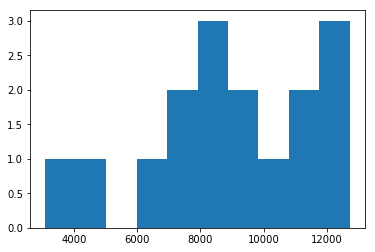

S Cells Range
2703.996621893606 16212.452440250183


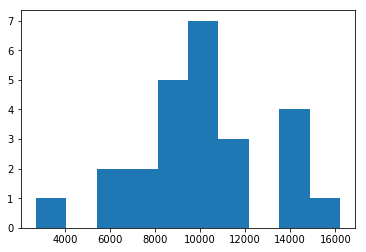

G2M Cells Range
5774.304705253046 20636.723672312444


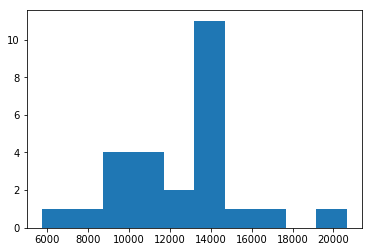



A1_G1
0.2329294110946436
A2_G1
0.0
A3_S
0.0
A4_S
0.4380075862828297
A5_G2M
0.13747974402149787
A6_G2M
0.20465354122257878
A7_G1
-0.5355139523044629
A8_G1
-0.385817902838567
A9_S
-0.06903205400816115
A10_S
0.4324624675385467
A11_G2M
-0.45111465029379955
A12_G2M
0.3932489837574669
A2b_G1
-1.284021500109713
B2_G1
0.16377734592483026
A4b_S
-0.018380267610377865
B5_G2M
0.4132025467664326
B6_G2M
0.0
A8b_G1
-0.4773264978700651
B8_G1
0.0
B9_S
-0.3971501638054401
B10_S
-0.8619056754047757
B11_G2M
0.3993555000230971
B12_G2M
0.0
C1_G1
0.0
C2_G1
0.0
C3_S
-0.7678946183866728
A12b_G2M
-0.16783092284300222
C1b_G1
0.0
C6_G2M
0.37824215288761703
C7_G1
0.09534024648427111
C8_G1
0.0
C9_S
-0.20803722002842764
C10_S
0.3231809627033596
C11_G2M
0.3064951167055383
C12_G2M
-0.027246016162212824
D1_G1
0.0
D2_G1
-0.34373063349524235
D3_S
-0.16423608500929715
C3b_S
-0.2432664122248591
C4b_S
0.095958827529719
D6_G2M
0.08246084723870897
D7_G1
0.0
D8_G1
-1.8043279983140943
D9_S
0.0
D10_S
-0.1903304620267717
D11_G2

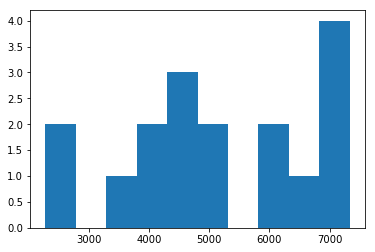

S Cells Range
2433.739363515137 10669.317983789046


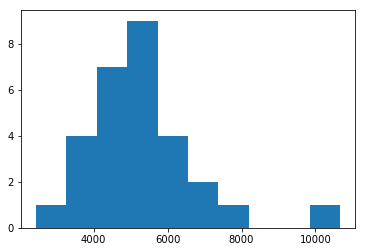

G2M Cells Range
3230.9972598836766 9317.43371729894


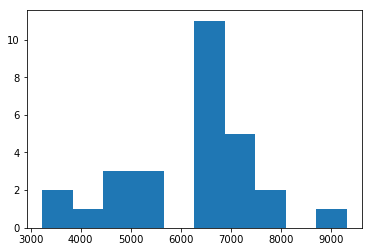



A1_G1
0.1512318844375132
A2_G1
0.0
A3_S
-0.3730521286294213
A4_S
0.5311849762464821
A5_G2M
-0.010394832764596847
A6_G2M
0.3224154222646676
A7_G1
-0.28234593148699855
A8_G1
-0.7688961598449082
A9_S
-0.412255097568128
A10_S
0.1955752083927128
A11_G2M
0.27069637780355
A12_G2M
0.2239408086945525
A2b_G1
0.0
B2_G1
0.3447758099601692
A4b_S
0.06319066518991091
B5_G2M
0.27417499226793907
B6_G2M
0.0
A8b_G1
0.0
B8_G1
-1.1038896625567147
B9_S
0.08764256827848976
B10_S
0.02327649324360317
B11_G2M
0.40245296292931587
B12_G2M
0.0
C1_G1
-0.2363257506727865
C2_G1
-1.3061833823845999
C3_S
-0.10424293442057786
A12b_G2M
-0.0890122073547238
C1b_G1
0.0
C6_G2M
0.3696138552781506
C7_G1
0.0698652692378315
C8_G1
0.0
C9_S
-0.10639271486415292
C10_S
0.2411022981464703
C11_G2M
0.3766479091279305
C12_G2M
0.1590842753988601
D1_G1
0.0
D2_G1
-0.19129076926675262
D3_S
-0.08260840035090267
C3b_S
-0.22678576500593983
C4b_S
-0.04540104771388059
D6_G2M
0.2063601540211248
D7_G1
0.0
D8_G1
-0.3691982001929597
D9_S
-0.562590

In [17]:
for gene_name in ("CCNA2", "CCNB2"):# "E2F2","PCNA", "RRM2","RFC4","CCNB1", "CCNB2"
    print(gene_name)
    print("Leg Tissue TPM")
    print(gene_name_to_tpm_dict[gene_name])
    print("Avg Tissue TPM")
    print(avg_gene_name_to_tpm_dict[gene_name])
    print("Internal Cell Average TPM (knowing phase of cell)")
    print((sum(G1_gene_ranges[gene_name])/len(G1_gene_ranges[gene_name]) + (sum(S_gene_ranges[gene_name])/len(S_gene_ranges[gene_name])) + (sum(G2M_gene_ranges[gene_name])/len(G2M_gene_ranges[gene_name])))/3)  
    print("Internal Cell Average, phase agnostic")
    print((sum(G1_gene_ranges[gene_name]) + sum(S_gene_ranges[gene_name]) + sum(G2M_gene_ranges[gene_name]))/len(SC_df.columns))
    print("G1 Cells Range")
    print(str(min(G1_gene_ranges[gene_name])) + " " + str(max(G1_gene_ranges[gene_name])))
    import matplotlib.pyplot as plt
    plt.hist(G1_gene_ranges[gene_name])
    plt.show()
    print("S Cells Range")
    print(str(min(S_gene_ranges[gene_name])) + " " + str(max(S_gene_ranges[gene_name])))
    import matplotlib.pyplot as plt
    plt.hist(S_gene_ranges[gene_name])
    plt.show()
    print("G2M Cells Range")
    print(str(min(G2M_gene_ranges[gene_name])) + " " + str(max(G2M_gene_ranges[gene_name])))
    import matplotlib.pyplot as plt
    plt.hist(G2M_gene_ranges[gene_name])
    plt.show()
    print("\n")
    for cell_name in SC_log_norm_df:
        print(cell_name)
        print(SC_log_norm_df[cell_name][gene_name])

# Now, get the subset of intersecting genes, try using the actual depletion for the best match...

In [63]:
# Read in the micro-array data - so far only founds matches between 1230 genes in whitfield in the 56K genes from GTEX
# TODO - get better name mapping
# this is v2: sc->ma w int TPM, points!!!
import math
import numpy as np
count = 0
count_found = 0
whitfield_micro_array_df = pd.read_csv("Whitfield_2013_cell_cycle_2830_all_scores.csv")

def get_coarse_phase(angle):
    predicted_phase = -1
    if angle >= 0 and angle <= 2:
        predicted_phase = "S"
    elif angle > 2 and angle <= 4.8:
        predicted_phase = "G2M"
    elif angle > 4.8 and angle <= 5.9:
        predicted_phase = "G1"
    elif angle > 5.9:
        predicted_phase = "S"
    return predicted_phase

gene_names_with_micro_array_data = list()

time_course_1_angles_list = list()
time_course_2_angles_list = list()
time_course_3_angles_list = list()
time_course_4_angles_list = list()
time_course_all_phases_list = list()
time_course_all_angles_list = list()
names_for_all_time_courses_list = list()
gene_name_to_time_course_expressions_dict = dict()

# calculate the angles for the 4 time courses
for i in range(0,40,2): #t-course 1 T = 17.65, φ = 0.0
    #print(math.atan2(math.sin((i/17.65)*2*math.pi),math.cos((i/17.65)*2*math.pi))) # with negative radians
    angle = ((i/17.65)*2*math.pi)%(2*math.pi)
    time_course_1_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle)) # 0 to 2pi
    names_for_all_time_courses_list.append("t1_" + str(i))
for i in range(0,48,2): #t-course 2 T = 18.6, φ = 0.0
    #print(math.atan2(math.sin((i/18.6)*2*math.pi),math.cos((i/18.6)*2*math.pi))) # with negative radians
    angle = ((i/18.6)*2*math.pi)%(2*math.pi)
    time_course_2_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle))
    names_for_all_time_courses_list.append("t2_" + str(i))
for i in range(0,48,2): #t-course 3 T = 18, φ = 0.0
    #print(math.atan2(math.sin((i/18)*2*math.pi),math.cos((i/18)*2*math.pi))) # with negative radians
    angle = ((i/18)*2*math.pi)%(2*math.pi)
    time_course_3_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle))
    names_for_all_time_courses_list.append("t3_" + str(i))
for i in range(0,46,2): #t-course 4 T = 23.95, φ = 2.3
    #print(math.atan2(math.sin((i/23.95)*2*math.pi + 2.3),math.cos((i/23.95)*2*math.pi + 2.3))) # with negative radians
    angle = ((i/23.95)*2*math.pi + 2.3)%(2*math.pi)
    time_course_4_angles_list.append(angle) # 0 to 2pi
    time_course_all_angles_list.append(angle) # 0 to 2pi
    time_course_all_phases_list.append(get_coarse_phase(angle))
    names_for_all_time_courses_list.append("t4_" + str(i))    
    
    
for index, row in whitfield_micro_array_df.iterrows():
    count +=1
    name = str(row['NAME'])
    if (name != 'nan'):
        #print("___" + name + "___")
        names = name.split("^")
        if (len(names) > 1):
            #print("___" + names[1] + "___")
            gene_name = names[1].strip()
            if (not(gene_name in gene_names_with_micro_array_data)):
                
                
                ####!!!! cut-off to have just a few top cycling genes
                scaled_fourier_score = float(row['Scaled Fourier'])
                #if (scaled_fourier_score < 10.0):
                 #   continue
                    
                
                #print(gene_name + " is found")
                gene_names_with_micro_array_data.append(gene_name)
                count_found += 1
                gene_name_to_time_course_expressions_dict[gene_name] = dict()
                gene_name_to_time_course_expressions_dict[gene_name]["one"] = list()
                
                
                new_row = row[11:31].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[11:31] = new_row
            
                new_row = row[32:56].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[32:56] = new_row
                
                new_row = row[57:81].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[57:81] = new_row
                
                new_row = row[82:105].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[82:105] = new_row
                
                
                #TODO: for now adding zero to missing time courses and samples - valid for all things?
                
                for i in range(11,31):
                    gene_name_to_time_course_expressions_dict[gene_name]["one"].append(row[i])
                gene_name_to_time_course_expressions_dict[gene_name]["two"] = list()
                for i in range(32,56):
                    gene_name_to_time_course_expressions_dict[gene_name]["two"].append(row[i])
                gene_name_to_time_course_expressions_dict[gene_name]["three"] = list()
                for i in range(57,81):
                    gene_name_to_time_course_expressions_dict[gene_name]["three"].append(row[i])
                gene_name_to_time_course_expressions_dict[gene_name]["four"] = list()
                for i in range(82,105):
                    gene_name_to_time_course_expressions_dict[gene_name]["four"].append(row[i])
    
                gene_name_to_time_course_expressions_dict[gene_name]["sine"] = row['Sin']
                gene_name_to_time_course_expressions_dict[gene_name]["cosine"] = row['Cos']
                gene_name_to_time_course_expressions_dict[gene_name]["phase"] = row['Phase'].strip()
                gene_name_to_time_course_expressions_dict[gene_name]["fourier_score"] = scaled_fourier_score
print(count_found)

1827


In [64]:
# OK, try to find direct matches between depletion; not pairs of values...
# this is v2: sc->ma w int TPM, points!!!
SC_our_assignment_tupples_list = list()
for cell_name in SC_df:
    
    # get a set of genes that are non-zero in that cell, and properly get a percentage
    count = 0
    whitfield_subset_micro_array_df = pd.DataFrame(columns = range(0,91))
    cell_cycle_genes_for_analysis = list()
    for gene_name, row in SC_log_norm_df.iterrows():
        if gene_name in gene_names_with_micro_array_data and SC_log_norm_df[cell_name][gene_name]:
            count += 1
            cell_cycle_genes_for_analysis.append(gene_name)
            whitfield_subset_micro_array_df.loc[gene_name] = gene_name_to_time_course_expressions_dict[gene_name]["one"] + gene_name_to_time_course_expressions_dict[gene_name]["two"] + gene_name_to_time_course_expressions_dict[gene_name]["three"] + gene_name_to_time_course_expressions_dict[gene_name]["four"]
            #print(whitfield_subset_micro_array_df.loc[gene_name])
    print(str(count) + " genes used for cell " + cell_name)
    #break
    
    #print(whitfield_subset_micro_array_df)
    
    all_genes_angle_list = list()
    all_genes_sine_sum = 0
    all_genes_cosine_sum = 0
    count = 0
    genes_greater_than_max = 0
    genes_less_than_min = 0
    for gene_name in cell_cycle_genes_for_analysis:
        expression_scRNA = SC_log_norm_df[cell_name][gene_name] # take the log normalized data
        #print(gene_name)
        #print(expression_scRNA)
        #print(SC_df[cell_name][gene_name])
        #print("whitfield")
        if (max(whitfield_subset_micro_array_df.loc[gene_name]) < expression_scRNA):
            genes_greater_than_max += 1
        if (min(whitfield_subset_micro_array_df.loc[gene_name]) > expression_scRNA):
            genes_less_than_min += 1
        if (not expression_scRNA): # no reads in single cell, do not consider
            print("BUG!!! for " + cell_name + " we are considering " + gene_name + " with no expression!!!")
            continue

        # process the first time course
        best_diff_1 = math.inf
        best_angle_1 = -1
        for i in range(0, 20):
            diff = abs(whitfield_subset_micro_array_df.loc[gene_name][i+0] - expression_scRNA)
            if (diff < best_diff_1 and (whitfield_subset_micro_array_df.loc[gene_name][i+0] != 0)):
                best_diff_1 = diff
                best_angle_1 = time_course_1_angles_list[i]

        # process the second time course
        best_diff_2 = math.inf
        best_angle_2 = -1
        for i in range(0, 24):
            diff = abs(whitfield_subset_micro_array_df.loc[gene_name][i+20] - expression_scRNA)
            if (diff < best_diff_2 and (whitfield_subset_micro_array_df.loc[gene_name][i+20] != 0)):
                best_diff_2 = diff
                best_angle_2 = time_course_2_angles_list[i]


        # process the third time course
        best_diff_3 = math.inf
        best_angle_3 = -1
        for i in range(0, 24):
            diff = abs(whitfield_subset_micro_array_df.loc[gene_name][i+44] - expression_scRNA)
            if (diff < best_diff_3):
                best_diff_3 = diff
                best_angle_3 = time_course_3_angles_list[i]
        
        # process the fourth time course
        best_diff_4 = math.inf
        best_angle_4 = -1
        for i in range(0, 23):
            diff = abs(whitfield_subset_micro_array_df.loc[gene_name][i+68] - expression_scRNA)
            if (diff < best_diff_4):
                best_diff_4 = diff
                best_angle_4 = time_course_4_angles_list[i]
        
        count += 1
        
        
        # HERE, try to use the best of the 4 angles
        if (best_diff_1 == min((best_diff_1, best_diff_2, best_diff_3, best_diff_4))):
            average_gene_angle = best_angle_1
        elif (best_diff_2 == min((best_diff_1, best_diff_2, best_diff_3, best_diff_4))):
            average_gene_angle = best_angle_2
        elif (best_diff_3 == min((best_diff_1, best_diff_2, best_diff_3, best_diff_4))):
            average_gene_angle = best_angle_3
        elif (best_diff_4 == min((best_diff_1, best_diff_2, best_diff_3, best_diff_4))):
            average_gene_angle = best_angle_4
        
        # no repeats
        all_genes_sine_sum += math.sin(average_gene_angle)
        all_genes_cosine_sum += math.cos(average_gene_angle)
        all_genes_angle_list.append(average_gene_angle)
        #print(whitfield_subset_micro_array_df.loc[gene_name][0:91])
        #print(expression_scRNA)
        
    #print(str(genes_greater_than_max) + " genes have expression > max of timecourse")
    #print(str(genes_less_than_min) + " genes have expression < min of timecourse") 
    #import matplotlib.pyplot as plt
    #plt.hist(all_genes_angle_list, bins=100)
    #plt.xlabel('Angles of Genes voting for Single Cell ' + cell_name)
    #plt.ylabel('Frequency')
    #plt.title('Angle Distribution')
    #plt.show()
    average_angle_across_all_genes = math.atan2(all_genes_sine_sum, all_genes_cosine_sum)
    #print(average_angle_across_all_genes)
    if (average_angle_across_all_genes < 0):
        average_angle_across_all_genes += 2*math.pi
    #print(average_angle_across_all_genes)
    predicted_phase = -1
    if average_angle_across_all_genes >= 0 and average_angle_across_all_genes <= 2:
        predicted_phase = "S"
    elif average_angle_across_all_genes > 2 and average_angle_across_all_genes <= 4.8:
        predicted_phase = "G2M"
    elif average_angle_across_all_genes > 4.8 and average_angle_across_all_genes <= 5.9:
        predicted_phase = "G1"
    elif average_angle_across_all_genes > 5.9:
        predicted_phase = "S"
    print(predicted_phase)
    SC_our_assignment_tupples_list.append((cell_name, predicted_phase))

1182 genes used for cell t1_0_S
S
1184 genes used for cell t1_2_S
S
1193 genes used for cell t1_4_S
S
1144 genes used for cell t1_6_G2M
S
1178 genes used for cell t1_8_G2M
G2M
1190 genes used for cell t1_10_G2M
G2M
1184 genes used for cell t1_12_G2M
G2M
1183 genes used for cell t1_14_G1
G2M
1196 genes used for cell t1_16_G1
S
1190 genes used for cell t1_18_S
S
1191 genes used for cell t1_20_S
S
1187 genes used for cell t1_22_S
S
1180 genes used for cell t1_24_G2M
G2M
1178 genes used for cell t1_26_G2M
G2M
1161 genes used for cell t1_28_G2M
G2M
983 genes used for cell t1_30_G2M
G2M
1178 genes used for cell t1_32_G1
S
1195 genes used for cell t1_34_G1
S
1192 genes used for cell t1_36_S
S
1164 genes used for cell t1_38_S
S
1175 genes used for cell t2_0_S
S
1177 genes used for cell t2_2_S
S
1169 genes used for cell t2_4_S
S
1177 genes used for cell t2_6_G2M
S
1177 genes used for cell t2_8_G2M
G2M
1173 genes used for cell t2_10_G2M
G2M
1173 genes used for cell t2_12_G2M
G2M
1177 genes used 

In [65]:
S_tp = 0
S_fp = 0
S_fn = 0
G2M_tp = 0
G2M_fp = 0
G2M_fn = 0
G1_tp = 0
G1_fp = 0
G1_fn = 0    
 
for (cell_name, predicted_phase) in SC_our_assignment_tupples_list:
    if ("_S" in cell_name):
        if (predicted_phase == "S"):
            S_tp += 1
        else:
            S_fn += 1
            if (predicted_phase == "G2M"):
                G2M_fp += 1
            elif (predicted_phase == "G1"):
                G1_fp += 1
    elif ("_G2" in cell_name):        
        if (predicted_phase == "G2M"):
            G2M_tp += 1        
        else:
            G2M_fn += 1
            if (predicted_phase == "S"):
                S_fp += 1
            elif (predicted_phase == "G1"):
                G1_fp += 1
    elif ("_G1" in cell_name):
        if (predicted_phase == "G1"):
            G1_tp += 1
        else:
            G1_fn += 1
            if (predicted_phase == "S"):
                S_fp += 1
            elif (predicted_phase == "G2M"):
                G2M_fp += 1 

S_precision = S_tp / (S_tp + S_fp) if S_tp else 0
S_recall = S_tp / (S_tp + S_fn) if S_tp else 0
G2M_precision = G2M_tp / (G2M_tp + G2M_fp) if G2M_tp else 0
G2M_recall = G2M_tp / (G2M_tp + G2M_fn) if G2M_tp else 0
G1_precision = G1_tp / (G1_tp + G1_fp) if G1_tp else 0
G1_recall = G1_tp / (G1_tp + G1_fn) if G1_tp else 0
precision_avg = (S_precision + G2M_precision + G1_precision)/3
recall_avg = (S_recall + G2M_recall + G1_recall)/3
f1_score = 2*((precision_avg*recall_avg)/(precision_avg+recall_avg))
print("F1_score")
print(f1_score)

F1_score
0.7262530923831999
